Changes (JM):
- use test-public-face -> changed the training data code to only use a subset if not very huge
- use probability

In [1]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from facenet_pytorch import InceptionResnetV1
import torchvision.models as models
# model = models.vgg19(weights=VGG19_Weights.DEFAULT)
# print(model)

In [ ]:

# test = torch.nn.Sequential(*(list(mdl.children())[:-1]))
# print(test)

TRAIN USING  TEST-PUBLIC RELATIONSHIPS

In [6]:
!unzip '/content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-faces.zip' -d '/content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-faces'

Streaming output truncated to the last 5000 lines.
   creating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-faces/__MACOSX/test-public-faces/F0020/MID8/
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-faces/__MACOSX/test-public-faces/F0020/MID8/._P00209_face3.jpg  
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-faces/__MACOSX/test-public-faces/F0020/._MID8  
   creating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-faces/test-public-faces/F0020/MID9/
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-faces/test-public-faces/F0020/MID9/P08968_face1.jpg  
   creating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-faces/__MACOSX/test-public-faces/F0020/MID9/
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-faces/__MACOSX/test-public-faces/F0020/MID9/._P08968_face1.jpg  
  inflating: /content/drive/MyDrive/recognizi

In [11]:
!unzip '/content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-lists.zip' -d '/content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-lists'

Archive:  /content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-lists.zip
   creating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-lists/test-public-lists/
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-lists/test-public-lists/bb.csv  
   creating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-lists/__MACOSX/
   creating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-lists/__MACOSX/test-public-lists/
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-lists/__MACOSX/test-public-lists/._bb.csv  
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-lists/test-public-lists/gmgd.csv  
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-lists/__MACOSX/test-public-lists/._gmgd.csv  
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-lists/test-public-lists/gmgs.csv  
  inflating: /content/d

In [14]:
#combining all test-public-lists together
from glob import glob #for finding files recursively
test_public_list_folder = "/content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-lists/test-public-lists/"
all_test_public_csvs = glob(test_public_list_folder + "*.csv")
print(all_test_public_csvs)

In [33]:
#append all of them into a combined_csv
df_append = pd.DataFrame()
for csv_path in all_test_public_csvs:
  temp_df = pd.read_csv(csv_path)
  df_append = df_append.append(temp_df, ignore_index=True)

def remove_last_character(s):
    if isinstance(s, str) and len(s) > 0:
        return s[:-1]
    else:
        return s

# Apply the function to every column in the DataFrame
df_append= df_append.applymap(remove_last_character)

df_append.to_csv("/content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-relationships.csv", index=False)


<ipython-input-33-8f9bb84e1c46>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_append = df_append.append(temp_df, ignore_index=True)
<ipython-input-33-8f9bb84e1c46>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_append = df_append.append(temp_df, ignore_index=True)
<ipython-input-33-8f9bb84e1c46>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_append = df_append.append(temp_df, ignore_index=True)
<ipython-input-33-8f9bb84e1c46>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_append = df_append.append(temp_df, ignore_index=True)
<ipython-input-33-8f9bb84e1c46>:5: FutureWarning: The frame.append method is deprecated and 

Training Data

In [4]:
import pandas as pd
from glob import glob #for finding files recursively
from collections import defaultdict

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as dset

from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision.models import *
from torchvision.datasets import ImageFolder
from torch.autograd import Variable

In [5]:
!unzip '/content/drive/MyDrive/recognizing-faces-in-the-wild/train-faces.zip' -d '/content/drive/MyDrive/recognizing-faces-in-the-wild/train-faces'

Archive:  /content/drive/MyDrive/recognizing-faces-in-the-wild/train-faces.zip
replace /content/drive/MyDrive/recognizing-faces-in-the-wild/train-faces/F0750/MID1/P07859_face1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [34]:
# relationshipsCSV = "/content/drive/MyDrive/recognizing-faces-in-the-wild/train_relationships.csv"
# train_images_folder = '/content/drive/MyDrive/recognizing-faces-in-the-wild/train-faces/'

relationshipsCSV = "/content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-relationships.csv"
train_images_folder = "/content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-faces/test-public-faces/"

In [35]:
available_images = glob(train_images_folder + "*/*/*.jpg")
'''
Only for windows pc:
'''
# for a in range(0, len(available_images)):
#     available_images[a] = available_images[a].replace("\\", "/")

all_ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in available_images] #all the peoplex

In [30]:
print(len(all_ppl))

20726


In [63]:
#creating the training set
personPathFile = defaultdict(list)
for x in available_images:
    personPathFile[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

#read from the csv to create a list of tuples
relationships = pd.read_csv(relationshipsCSV)
relationship_pairs = [(row['p1'], row['p2']) for index, row in relationships.iterrows()] # Create a list of tuples
relationship_pairs = [x for x in relationship_pairs if x[0] in all_ppl and x[1] in all_ppl] #data cleaning

# #converting into dictionary of person is related to this list of people
relationshipDict = defaultdict(list)
for item in relationship_pairs:
  relationshipDict[item[0]].append(item[1]) #you do not need to consider the item[1] because the CSV is already pretty clean

#create more data by finding the 'negative pair'
notRelationshipDict = defaultdict(list)
set_all_ppl = set(all_ppl)
#for each key(person) in the relationship dictionary, find the non-relations
count = 0
for k,v in relationshipDict.items():
    notRelationshipDict[k]=list(set_all_ppl-set(v))


# convert both dictionaries into a list of tuples with 1, 0 as labels
# for each of the image, take the first image path stored in the dictionary made earlier
# then take each of the path file in the item

trainData = []

for k,v in relationshipDict.items():
    for relation in v:
      for i in range(0, len(personPathFile[k])):
        #I AM TRYING TO REDUCE THE NUMBER OF POSITIVE RELATIONS JM
        if (i%4==0):
          continue
        trainData.append((personPathFile[k][i], personPathFile[relation][0],1))







        #uncomment to add more data
        # try:
        #   trainData.append((personPathFile[k][i], personPathFile[relation][1],1))
        # except:
        #   pass

positiveRelationsCount = len(trainData)
print("Current Length of positive relationships: ", len(trainData))
NUM_DATA = 1 #increaase this for more data
for k,v in notRelationshipDict.items():
  count1 = 0
  count2 = 0
  for relations in v:
    if count1 <= NUM_DATA+3 and k[:5]==relations[:5]:
      for i in range(0, 5):
        try:
          trainData.append((personPathFile[k][i], personPathFile[relations][0],0))
        except:
          pass
      count1 += 1
    elif count2 <= NUM_DATA and k[:5]!=relations[:5]:
      trainData.append((personPathFile[k][0], personPathFile[relations][0],0))
      count2 += 1
    # elif count1>NUM_DATA+3 and count2>NUM_DATA:
    #   break
    elif count1>NUM_DATA and count2>NUM_DATA:
      break




# '''

# # Storing the list of tuples in a text file
# with open('Cleaned_Data.txt', 'w') as file:
#     for item in trainData:
#         file.write(f"{item[0]}, {item[1]}, {item[2]}\n")


# trainData1 = []
# with open('Cleaned_Data.txt', 'r') as file:
#     for l in file:
#         eachTuple = l.strip().split(', ')
#         trainData1.append(((eachTuple[0]), eachTuple[1], int(eachTuple[2])))


# '''

Current Length of positive relationships:  26576


In [64]:
len(trainData)

54139

In [65]:
#Checking whether the trainData is created correctly
print("Total Length of all relationships: ", len(trainData))
print(trainData[:100])

Total Length of all relationships:  54139
[('/content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-faces/test-public-faces/F0001/MID3/P00006_face2.jpg', '/content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-faces/test-public-faces/F0001/MID4/P00005_face1.jpg', 1), ('/content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-faces/test-public-faces/F0001/MID3/P00007_face3.jpg', '/content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-faces/test-public-faces/F0001/MID4/P00005_face1.jpg', 1), ('/content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-faces/test-public-faces/F0007/MID1/P00078_face3.jpg', '/content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-faces/test-public-faces/F0007/MID8/P00079_face4.jpg', 1), ('/content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-faces/test-public-faces/F0007/MID1/P00075_face2.jpg', '/content/drive/MyDrive/recognizing-faces-in-the-wild/test-public-faces/test-public-faces/F0007/MID8/

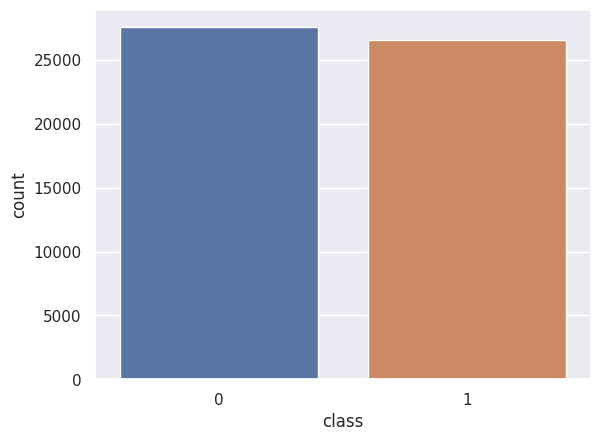

In [66]:
#checking the balance of positive and negative data
dfTrainData = pd.DataFrame (trainData, columns=['img1', 'img2', 'class'])
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="class", data=dfTrainData)

In [67]:
#use the pytorch built in Dataset function
class trainingDataset(Dataset):
    def __init__(self, _data, _transform=None):
        self.data = _data #choose either train or val dataset to use
        self.transform = _transform


    def __getitem__(self,index):

        first_img_path = self.data[index][0]
        second_img_path = self.data[index][1]
        img1Opened = Image.open(first_img_path)
        img2Opened = Image.open(second_img_path)


        #it is important to transform the images into tensor format
        if self.transform is not None:
            img1Opened = self.transform(img1Opened)
            img2Opened = self.transform(img2Opened)
        return img1Opened, img2Opened , self.data[index][2]

    def __len__(self):
        return len(self.data)#essential for choose the num of data in one epoch


In [68]:
from sklearn.model_selection import train_test_split
BATCH_SIZE=64
IMG_SIZE=100
NUM_WORKERS = 8


trainSet, valSet = train_test_split(trainData, test_size=0.1, random_state=42)
#TODO: Normalize the data


'''
transforms.GaussianBlur(kernel_size = 5, sigma=(0.1, 2.0)),
transforms.ColorJitter(brightness=0.4, contrast=0.1),
transforms.RandomGrayscale(p=0.5),
transforms.RandomHorizontalFlip(),
[transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.ToTensor()]
'''
#Training set and training loader
def createTrain(transformations):
  trainset = trainingDataset(_data=trainSet,
                                          _transform=transforms.Compose(transformations))

  trainloader = DataLoader(trainset,
                          shuffle=True,
                          num_workers=NUM_WORKERS,
                          batch_size=BATCH_SIZE)

  return trainloader



valset = trainingDataset(_data=valSet,
                                        _transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))


valloader = DataLoader(valset,
                        shuffle=True,
                        num_workers=NUM_WORKERS,
                        batch_size=BATCH_SIZE)





/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Define loss function and optimizer

Siamese Model

In [69]:
class SiameseNetwork(nn.Module):
    def __init__(self,mdl):

        super(SiameseNetwork, self).__init__()

        model = mdl

        for param in model.parameters():
          param.require_grad = False

        self.cnn1 = torch.nn.Sequential(*(list(model.children())[:-1][:-3]))

        # model.classifier = nn.Sequential(
        #     nn.Linear(3584,460),
        #     nn.ReLU(),
        #     nn.Linear(460, 230),
        #     nn.ReLU(),
        #     nn.Linear(230, 2)
        # )



        model.classifier = nn.Sequential(
            nn.Linear(3584,2048),
            nn.ReLU(),
            nn.Dropout(0.7),  # Add dropout for regularization
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256), # Apply batch normalization
            nn.Linear(256, 2)
        )


        self.fc = model.classifier


    def forward_one(self, x):
        return self.model(x)

    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)



        output = torch.cat((output1, output2),1)
        output = self.fc(output)
        return output


model = SiameseNetwork(InceptionResnetV1(pretrained='vggface2', classify=False))


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [70]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

Finetune Model

In [71]:
# Create the Siamese network
net = SiameseNetwork(InceptionResnetV1(pretrained='vggface2', classify=False)).cuda()
# Define the contrastive loss
criterion = nn.CrossEntropyLoss()

# Define the optimizer (e.g., Adam)
optimizer = optim.Adam(net.parameters(), lr=0.0005)


#move to gpu
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

# model_on_gpu = model.to(device)

In [72]:
print(len(valset)) #checking the length of the validation set
print(len(trainSet)) #checking the length of test set

5414
48725


In [75]:
import numpy as np
from PIL import Image
# Training loop

'''
transforms.GaussianBlur(kernel_size = 5, sigma=(0.1, 3.0)),
transforms.ColorJitter(brightness=0.7, contrast=0.3),
transforms.RandomGrayscale(p=0.5),
transforms.RandomHorizontalFlip(),
transforms.RandomCrop((75,75)),
[transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.ToTensor()]
'''

BATCH_SIZE=64
NUMBER_EPOCHS=30
epoch_accuracies = np.array([])
epoch_accuracies = np.array([])

net.train()
for epoch in range(1,NUMBER_EPOCHS+1):
    print("Epoch：", epoch)
    total_loss = 0

    #Change Data Augmentation every other epoch
    if epoch % 10 == 0 or epoch %10 == 1 or epoch %10 == 2 or epoch %10 == 3:
      print("Using no Data Augmentation")
      trainloader = createTrain([transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.ToTensor()])
    elif epoch %10 == 4 or epoch %10 == 5:
       print("Using greyscale Augmentation")
       trainloader = createTrain([transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.RandomGrayscale(p=0.5),transforms.ToTensor()])
    elif epoch %10 == 6 or epoch %10 == 7:
      print("Using GreyScale, Random Horizontal Flip, gaussian blur Data Augmentation")
      trainloader = createTrain([transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.RandomGrayscale(p=0.8),transforms.RandomHorizontalFlip(),transforms.GaussianBlur(kernel_size = 5, sigma=(0.1, 3.0)),transforms.ToTensor()])
    elif epoch %10 == 8 or epoch %10 == 9:
      print("Using GreyScale, Random Horizontal Flip, Data Augmentation")
      trainloader = createTrain([transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.RandomGrayscale(p=0.5),transforms.RandomHorizontalFlip(),transforms.ToTensor()])
    else:
      print("Using no Data Augmentation")
      trainloader = createTrain([transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.ToTensor()])

    for i, data in enumerate(trainloader,0):
        img0, img1 , labels = data
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
        optimizer.zero_grad()
        outputs = net(img0,img1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in valloader:
            img0, img1 , labels = data
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = net(img0,img1)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    accuracy = 100 * correct_val / total_val
    epoch_accuracies = np.append(epoch_accuracies, accuracy)
    print(f"Epoch {epoch}/{NUMBER_EPOCHS}, Loss: {total_loss/len(trainloader)}, Accuracy: {accuracy}")




best_accuracy = np.amax(epoch_accuracies)
best_epoch = epoch_accuracies.argmax()
print('END TRAINING: BEST EPOCH: ', best_epoch, ' WITH ACCURACY: ', best_accuracy)


Epoch： 1
Using no Data Augmentation
Epoch 1/30, Loss: 0.36787706728917097, Accuracy: 87.38455855190247
Epoch： 2
Using no Data Augmentation
Epoch 2/30, Loss: 0.23954377750673006, Accuracy: 91.44809752493535
Epoch： 3
Using no Data Augmentation
Epoch 3/30, Loss: 0.19127462380455704, Accuracy: 92.20539342445511
Epoch： 4
Using greyscale Augmentation
Epoch 4/30, Loss: 0.18302899011437662, Accuracy: 92.87033616549687
Epoch： 5
Using greyscale Augmentation
Epoch 5/30, Loss: 0.15599843185502557, Accuracy: 93.0365718507573
Epoch： 6
Using GreyScale, Random Horizontal Flip, gaussian blur Data Augmentation
Epoch 6/30, Loss: 0.2719112393541599, Accuracy: 92.1499815293683
Epoch： 7
Using GreyScale, Random Horizontal Flip, gaussian blur Data Augmentation
Epoch 7/30, Loss: 0.20798392513683775, Accuracy: 92.16845216106391
Epoch： 8
Using GreyScale, Random Horizontal Flip, Data Augmentation
Epoch 8/30, Loss: 0.1685577681351678, Accuracy: 92.98115995567048
Epoch： 9
Using GreyScale, Random Horizontal Flip, Da

In [78]:
torch.save(net, "/content/drive/MyDrive/recognizing-faces-in-the-wild/FacenetV4Prob.pth")

In [79]:
class testDataset(Dataset):

    def __init__(self,transform=None):
        self.test_df = pd.read_csv("/content/drive/MyDrive/recognizing-faces-in-the-wild/sample_submission.csv")
        self.transform = transform

    def __getitem__(self,index):

        img0_path = self.test_df.iloc[index].img_pair.split("-")[0]
        img1_path = self.test_df.iloc[index].img_pair.split("-")[1]

        img0 = Image.open('test/'+img0_path)
        img1 = Image.open('test/'+img1_path)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1

    def __len__(self):
        return len(self.test_df)

In [80]:
testset = testDataset(transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
testloader = DataLoader(testset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=1)#Both extra workers and batch size lead to data out of order, the submission.csv will be

In [82]:
%cd /content/drive/MyDrive/recognizing-faces-in-the-wild

/content/drive/MyDrive/recognizing-faces-in-the-wild


In [84]:
import numpy as np
net.eval()
test_df = pd.read_csv("/content/drive/MyDrive/recognizing-faces-in-the-wild/sample_submission.csv")
predictions=[]
count = 0
with torch.no_grad():
    for data in testloader:
        if count%250 == 0:
          print(count)
        count+=1
        img0, img1 = data
        img0, img1 = img0.cuda(), img1.cuda()
        output = net(img0,img1)
        probabilities = torch.softmax(output, dim=1)

        class_1_probabilities = probabilities[:, 1]
        predictions = np.concatenate((predictions,class_1_probabilities.cpu().numpy()),0)

test_df['is_related'] = predictions
test_df.head(50)#show the result to be committed
test_df.to_csv("/content/drive/MyDrive/recognizing-faces-in-the-wild/test_Results_FacenetV4Prob.csv", index=False)

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
